In [1]:
import torch
import torchvision
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [2]:
# 1.Get data
import requests
from pathlib import Path
from zipfile import ZipFile

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"Directory {image_path} exists.")
else:
    print(f"Directory {image_path} no found, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    print("Done.")
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        print(f"Downloading pizza_steak_sushi data...")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
        print("Done.")
    
    with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"Unzipping all pizza_steak_sushi data...")
        zip_ref.extractall(image_path)
        print("Done.")


Directory data\pizza_steak_sushi exists.


In [3]:
# 2. Become one with data
import os

def walk_through_data(dir_path):
    for dirpaths, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in path:'{dirpaths}'")

walk_through_data(image_path)

There are 2 directories and 0 files in path:'data\pizza_steak_sushi'
There are 3 directories and 0 files in path:'data\pizza_steak_sushi\test'
There are 0 directories and 25 files in path:'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 files in path:'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 files in path:'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 files in path:'data\pizza_steak_sushi\train'
There are 0 directories and 78 files in path:'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 files in path:'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 files in path:'data\pizza_steak_sushi\train\sushi'


In [4]:
from PIL import Image
import random

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Visualize an image
random_image_list = list(image_path.glob("*/*/*.jpg"))
random.seed(42)
random_image_list_choice = random.choice(random_image_list)

img = Image.open(random_image_list_choice)
img.show()

(-0.5, 511.5, 407.5, -0.5)

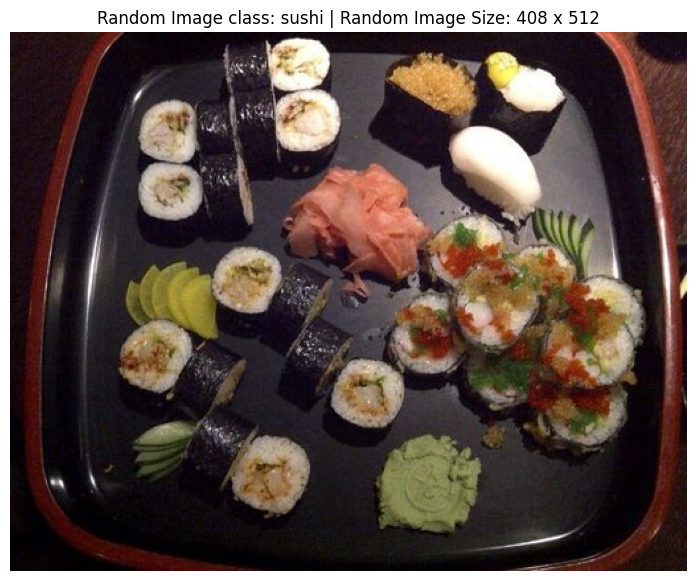

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Do the image visualization with matplotlib
random_image_list_choice_class = random_image_list_choice.parent.name
img_as_numpy = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_numpy)
plt.title(f"Random Image class: {random_image_list_choice_class} | Random Image Size: {img.height} x {img.width}")
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

# 3.1 Transforming data with torchvision.transforms
# Write transform for turning images into tensors
data_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

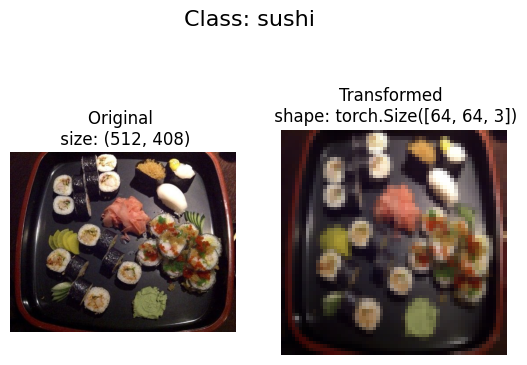

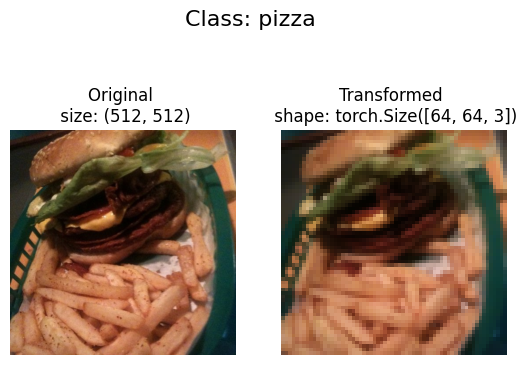

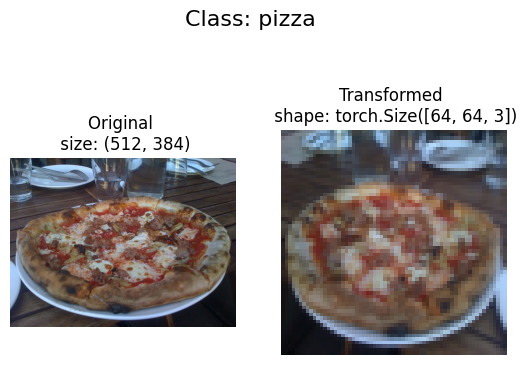

In [7]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n size: {f.size}")
            ax[0].axis("off")
            
            transformed_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed \n shape: {transformed_img.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.name}", fontsize=16)

plot_transformed_images(random_image_list, data_transform)

### Load image data using `ImageFolder`

In [8]:
# Use ImageFolder to create dataset(s)
train_data_10_percent = ImageFolder(
    train_dir,
    data_transform,
    target_transform=None,
)

test_data_10_percent = ImageFolder(
    test_dir,
    data_transform,
    target_transform=None
)

class_names = train_data_10_percent.classes
class_dict = train_data_10_percent.class_to_idx
class_names, class_dict, len(train_data_10_percent), len(test_data_10_percent)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}, 225, 75)

In [9]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_10_percent = DataLoader(
    train_data_10_percent, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_10_percent = DataLoader(
    test_data_10_percent,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

len(train_dataloader_10_percent), len(test_dataloader_10_percent)

(8, 3)

In [10]:
image, label = next(iter(train_dataloader_10_percent))
print(f"Image shape: {image.shape}")
print(f"Image class: {class_names[label[0]]}")

Image shape: torch.Size([32, 3, 64, 64])
Image class: sushi


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [11]:
from torchinfo import summary

class TinyVGG(nn.Module):
    def __init__(self, input_channel = 3, hidden_unit = 10, output_channel = len(class_names)):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channel, hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_unit * 16 * 16, output_channel)
        )
    
    def forward(self, x):
        y = self.classifier(self.block_2(self.block_1(x)))
        return y

model_0 = TinyVGG().to(device)

summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 10, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 10, 32, 32]          910
│    └─ReLU: 2-7                         [32, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 10, 32, 32]          910
│    └─ReLU: 2-9                         [32, 10, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 10, 16, 16]          --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [12]:
def train_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_func: torch.nn.Module,
        optimizer: torch.optim.Optimizer
):
    model.train()
    train_loss, train_acc = 0, 0
    correct_samples, total_samples = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        train_logits = model(X)
        loss = loss_func(train_logits, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_probs = torch.softmax(train_logits, dim=1)
        train_preds = torch.argmax(train_probs, dim=1)
        correct_samples += (y == train_preds).sum().item()
        total_samples += len(y)
    
    train_loss /= len(dataloader)
    train_acc = correct_samples / total_samples
    
    return train_loss, train_acc
        

In [13]:
def test_step(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_func: torch.nn.Module
):
    model.eval()
    test_loss, test_acc = 0, 0
    correct_samples, total_samples = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_logits = model(X)
            loss = loss_func(test_logits, y)
            test_loss += loss.item()
            
            test_preds = torch.argmax(test_logits, dim=1)
            correct_samples += (y == test_preds).sum().item()
            total_samples += len(y)
        
        test_loss /= len(dataloader)
        test_acc = correct_samples / total_samples
    
    return test_loss, test_acc

In [14]:
from tqdm.auto import tqdm

def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_func: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        epochs: int = 5
):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_func, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_func)
        
        print(f"Epoch: {epoch + 1} |"
              f"Train loss: {train_loss:.4f} | "
              f"Train Acc: {100 * train_acc:.2f}% | "
              f"Test loss: {test_loss:.4f} |"
              f"Test Acc: {100 * test_acc:.2f}%")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(test_loss)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [23]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

model_0_results_5_epochs = train(model_0, train_dataloader_10_percent, test_dataloader_10_percent, loss_func, optimizer, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 1.0788 | Train Acc: 39.11% | Test loss: 1.0789 |Test Acc: 41.33%
Epoch: 2 |Train loss: 1.0361 | Train Acc: 36.00% | Test loss: 1.1052 |Test Acc: 33.33%
Epoch: 3 |Train loss: 1.0347 | Train Acc: 35.56% | Test loss: 1.1262 |Test Acc: 36.00%
Epoch: 4 |Train loss: 1.0341 | Train Acc: 47.56% | Test loss: 1.1335 |Test Acc: 37.33%
Epoch: 5 |Train loss: 0.9593 | Train Acc: 47.11% | Test loss: 1.1291 |Test Acc: 38.67%


In [24]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

model_0_results_20_epochs = train(model_0, train_dataloader_10_percent, test_dataloader_10_percent, loss_func, optimizer, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 0.9351 | Train Acc: 52.89% | Test loss: 1.0611 |Test Acc: 42.67%
Epoch: 2 |Train loss: 0.8892 | Train Acc: 52.44% | Test loss: 1.0501 |Test Acc: 44.00%
Epoch: 3 |Train loss: 0.8440 | Train Acc: 56.44% | Test loss: 1.1087 |Test Acc: 37.33%
Epoch: 4 |Train loss: 0.8380 | Train Acc: 58.22% | Test loss: 1.0574 |Test Acc: 38.67%
Epoch: 5 |Train loss: 0.7751 | Train Acc: 60.89% | Test loss: 1.0126 |Test Acc: 45.33%
Epoch: 6 |Train loss: 1.0063 | Train Acc: 58.67% | Test loss: 0.9607 |Test Acc: 44.00%
Epoch: 7 |Train loss: 0.7496 | Train Acc: 59.56% | Test loss: 1.0246 |Test Acc: 49.33%
Epoch: 8 |Train loss: 0.8055 | Train Acc: 62.67% | Test loss: 1.0333 |Test Acc: 42.67%
Epoch: 9 |Train loss: 0.9019 | Train Acc: 60.89% | Test loss: 1.0055 |Test Acc: 38.67%
Epoch: 10 |Train loss: 0.7964 | Train Acc: 64.00% | Test loss: 0.9511 |Test Acc: 49.33%
Epoch: 11 |Train loss: 0.7688 | Train Acc: 63.56% | Test loss: 0.9613 |Test Acc: 45.33%
Epoch: 12 |Train loss: 0.7809 | Train Acc

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(
    input_channel=3,
    hidden_unit=20,
    output_channel=len(class_names)
).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
model_1_results = train(model_1, train_dataloader_10_percent, test_dataloader_10_percent, loss_func, optimizer, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 1.1047 | Train Acc: 34.67% | Test loss: 1.1075 |Test Acc: 33.33%
Epoch: 2 |Train loss: 1.1228 | Train Acc: 34.67% | Test loss: 1.0987 |Test Acc: 33.33%
Epoch: 3 |Train loss: 1.0920 | Train Acc: 44.44% | Test loss: 1.0999 |Test Acc: 30.67%
Epoch: 4 |Train loss: 1.0912 | Train Acc: 50.22% | Test loss: 1.0758 |Test Acc: 46.67%
Epoch: 5 |Train loss: 1.0938 | Train Acc: 46.22% | Test loss: 1.0667 |Test Acc: 38.67%
Epoch: 6 |Train loss: 1.0501 | Train Acc: 51.11% | Test loss: 1.0836 |Test Acc: 45.33%
Epoch: 7 |Train loss: 0.9694 | Train Acc: 53.33% | Test loss: 1.1539 |Test Acc: 41.33%
Epoch: 8 |Train loss: 0.9197 | Train Acc: 53.78% | Test loss: 1.0241 |Test Acc: 41.33%
Epoch: 9 |Train loss: 0.9661 | Train Acc: 53.78% | Test loss: 0.9795 |Test Acc: 46.67%
Epoch: 10 |Train loss: 0.9091 | Train Acc: 55.56% | Test loss: 1.0392 |Test Acc: 44.00%
Epoch: 11 |Train loss: 0.9078 | Train Acc: 50.22% | Test loss: 1.0844 |Test Acc: 42.67%
Epoch: 12 |Train loss: 0.9640 | Train Acc

In [16]:
from typing import Tuple, List, Dict

def plot_loss_curves(results: Dict[str, List]):
    
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]
    
    test_loss = results["test_loss"]
    test_acc = results["test_acc"]
    
    epochs = range(len(train_loss))
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, test_acc, label="Test Acc")
    plt.title("Acc")
    plt.xlabel("Epochs")
    plt.legend()


## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [17]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
    print(f"Directory: {image_path} exists.")
else:
    print(f"Directory: {image_path} no found, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    print("Done!")
    
    with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi 20% data...")
        f.write(request.content)
        print("Done!")
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

Directory: data\pizza_steak_sushi_20_percent exists.


In [18]:
walk_through_data(image_path)

There are 2 directories and 0 files in path:'data\pizza_steak_sushi_20_percent'
There are 3 directories and 0 files in path:'data\pizza_steak_sushi_20_percent\test'
There are 0 directories and 46 files in path:'data\pizza_steak_sushi_20_percent\test\pizza'
There are 0 directories and 58 files in path:'data\pizza_steak_sushi_20_percent\test\steak'
There are 0 directories and 46 files in path:'data\pizza_steak_sushi_20_percent\test\sushi'
There are 3 directories and 0 files in path:'data\pizza_steak_sushi_20_percent\train'
There are 0 directories and 154 files in path:'data\pizza_steak_sushi_20_percent\train\pizza'
There are 0 directories and 146 files in path:'data\pizza_steak_sushi_20_percent\train\steak'
There are 0 directories and 150 files in path:'data\pizza_steak_sushi_20_percent\train\sushi'


In [19]:
# Creating the train and test paths
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

# Turn the 20 percent datapaths into Datasets and DataLoaders
simple_transform = v2.Compose([
    v2.Resize(size=(64, 64)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Create datasets
train_data_20_percent = ImageFolder(train_dir_20_percent, simple_transform, target_transform=None)
test_data_20_percent = ImageFolder(test_dir_20_percent, simple_transform, target_transform=None)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader_20_percent = DataLoader(test_data_20_percent, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [20]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(3, 10, len(class_names)).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)

model_2_results = train(model_2, train_dataloader_20_percent, test_dataloader_20_percent, loss_func, optimizer, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 |Train loss: 1.1074 | Train Acc: 35.11% | Test loss: 1.0975 |Test Acc: 38.67%
Epoch: 2 |Train loss: 1.1013 | Train Acc: 34.89% | Test loss: 1.1002 |Test Acc: 40.00%
Epoch: 3 |Train loss: 1.0988 | Train Acc: 32.67% | Test loss: 1.0962 |Test Acc: 38.67%
Epoch: 4 |Train loss: 1.0959 | Train Acc: 36.67% | Test loss: 1.0886 |Test Acc: 48.00%
Epoch: 5 |Train loss: 1.0803 | Train Acc: 50.67% | Test loss: 1.0604 |Test Acc: 47.33%
Epoch: 6 |Train loss: 1.0207 | Train Acc: 50.22% | Test loss: 0.9969 |Test Acc: 46.67%
Epoch: 7 |Train loss: 0.9323 | Train Acc: 55.78% | Test loss: 0.8770 |Test Acc: 61.33%
Epoch: 8 |Train loss: 0.8574 | Train Acc: 61.11% | Test loss: 0.8845 |Test Acc: 59.33%
Epoch: 9 |Train loss: 0.8032 | Train Acc: 61.11% | Test loss: 0.8413 |Test Acc: 62.67%
Epoch: 10 |Train loss: 0.8026 | Train Acc: 66.44% | Test loss: 0.8363 |Test Acc: 62.67%
Epoch: 11 |Train loss: 0.7762 | Train Acc: 64.67% | Test loss: 0.8796 |Test Acc: 62.67%
Epoch: 12 |Train loss: 0.7550 | Train Acc

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [21]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [22]:
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

(-0.5, 3023.5, 4031.5, -0.5)

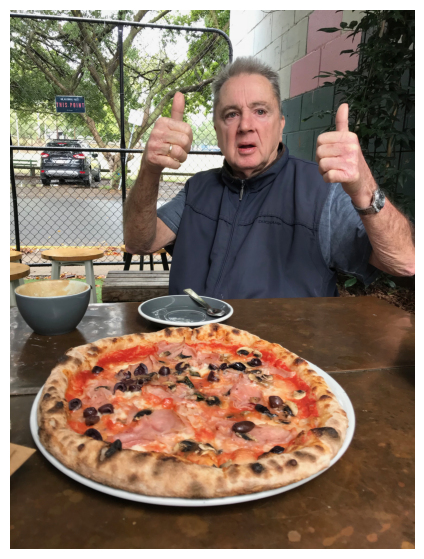

In [23]:
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)

(-0.5, 63.5, 63.5, -0.5)

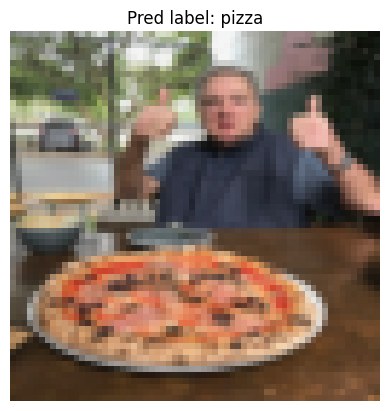

In [25]:
model_2.eval()
with torch.inference_mode():
    img = img / 255.
    resize = v2.Resize(size=(64, 64))
    img = resize(img)
    
    batched_img = img.unsqueeze(0).to(device)
    y_pred_logit = model_2(batched_img)
    pred_label = torch.argmax(y_pred_logit, dim=1)

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False)